In [1]:
import sys
sys.path.append("../")

In [2]:
from pathlib import Path
from functools import partial

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from fastai.text import LanguageModelLoader, LanguageModelData
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
tokens = joblib.load("../data/tokens.pkl")

In [4]:
# Filter out empty texts
tokens = [x for x in tokens if x.shape[0] > 0]

In [5]:
trn_tokens, val_tokens = train_test_split(tokens, test_size=0.2)
val_tokens, tst_tokens = train_test_split(val_tokens, test_size=0.5)

In [6]:
def get_voc_stats(tokens):
    total_tokens = np.sum([x.shape[0] for x in tokens])
    unks = np.sum([np.sum(x == 1) for x in tokens])
    print("Total tokens: %d\nUnknown Percentage: %.2f %%" % (total_tokens, unks * 100 / total_tokens))
get_voc_stats(tokens)

Total tokens: 89299699
Unknown Percentage: 0.68 %


In [13]:
bptt = 100
batch_size = 128
n_tok = int(np.max([np.max(x) for x in tokens]) + 1)
trn_loader = LanguageModelLoader(
    np.concatenate(trn_tokens), batch_size, bptt)
val_loader = LanguageModelLoader(
    np.concatenate(val_tokens), batch_size, bptt)
tst_loader = LanguageModelLoader(
    np.concatenate(tst_tokens), batch_size, bptt)

### QRNN Model

In [8]:
path = Path("../data/cache/lm/")
path.mkdir(parents=True, exist_ok=True)
model_data = LanguageModelData(
    path, pad_idx=0, n_tok=n_tok, trn_dl=trn_loader, val_dl=val_loader, test_ds=tst_loader
)

In [10]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=300, n_layers=4,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=True
)

epoch      trn_loss   val_loss                                
    0      9.667005   8.039155  



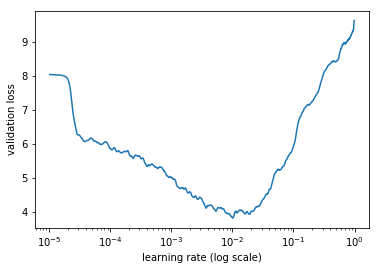

In [11]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [11]:
lrs = 2e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 5), cycle_len=20, use_wd_sched=True)

epoch      trn_loss   val_loss                                
    0      4.237627   4.015834  
    1      3.803474   3.52302                                 
    2      3.636249   3.351241                                
    3      3.570377   3.275911                                
    4      3.521982   3.217143                                
    5      3.466035   3.18096                                 
    6      3.461691   3.15281                                 
    7      3.446914   3.130973                                
    8      3.414688   3.115056                                
    9      3.407785   3.106338                                
    10     3.419165   3.091492                                
    11     3.39356    3.080882                                
    12     3.397776   3.073432                                
    13     3.393257   3.066951                                
    14     3.382788   3.059156                                
    15     3.381986   

[3.0371074495996746]

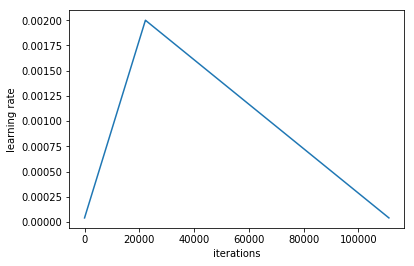

In [12]:
learner.sched.plot_lr()

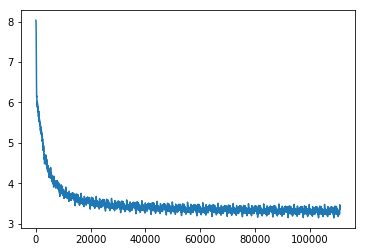

In [14]:
learner.sched.plot_loss()

In [16]:
learner.save("lm_qrnn")
learner.save_encoder("lm_qrnn_enc")

### LSTM

In [31]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=300, n_layers=3,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=False
)

 82%|████████▏ | 4553/5560 [05:56<01:18, 12.77it/s, loss=14.3]

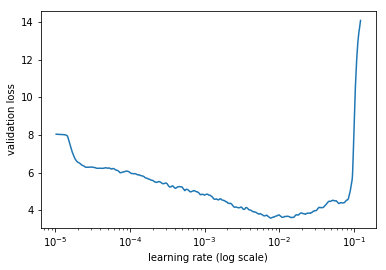

In [32]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [33]:
lrs = 3e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 5), cycle_len=20, use_wd_sched=True)

epoch      trn_loss   val_loss                                
    0      3.735518   3.557686  
    1      3.378875   3.133255                                
    2      3.273794   3.017984                                
    3      3.239015   2.966163                                
    4      3.183572   2.907244                                
    5      3.158002   2.878286                                
    6      3.138812   2.858471                                
    7      3.124154   2.836141                                
    8      3.107467   2.824919                                
    9      3.092159   2.808824                                
    10     3.078499   2.797607                                
    11     3.07259    2.789364                                
    12     3.061139   2.77668                                 
    13     3.048085   2.765979                                
    14     3.045886   2.759994                                
    15     3.033887   

[2.727246059349605]

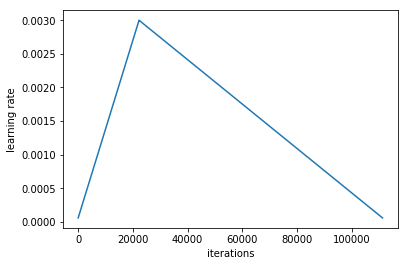

In [34]:
learner.sched.plot_lr()

In [35]:
learner.save("lm_lstm")
learner.save_encoder("lm_lstm_enc")

## Test the model

In [52]:
learner.model.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(3096, 300, padding_idx=0)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(3096, 300, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(300, 300)
      )
      (1): WeightDrop(
        (module): LSTM(300, 300)
      )
      (2): WeightDrop(
        (module): LSTM(300, 300)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=300, out_features=3096, bias=False)
    (dropout): LockedDropout()
  )
)

### Next Character Inference

In [53]:
mapping = joblib.load("../data/mapping.pkl")

In [54]:
itos = ['<unk>'] *  n_tok
for k, v in mapping.items():
    itos[v] = k

In [55]:
tokens = list(map(lambda x: mapping.get(x, 1), "德国是世界大国之一，其国内生产总值以国际汇率计"))
tokens

[122,
 24,
 23,
 146,
 277,
 32,
 24,
 65,
 25,
 3,
 97,
 24,
 167,
 92,
 286,
 256,
 912,
 48,
 24,
 375,
 1140,
 736,
 213]

In [56]:
logits, _, _ = learner.model(T(tokens).unsqueeze(1))
logits.shape

torch.Size([23, 3096])

In [57]:
sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
preds = []
for i in range(1, 4):
      preds.append(list(map(lambda x: itos[x], sorted_idx[:, -i])))
# preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
pd.DataFrame({"orig": [x for x in "德国是世界大国之一，其国内生产总值以国际汇率计 "], 
              "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

,orig,pred_1,pred_2,pred_3
0,德,,,
1,国,》,<unk>,的
2,是,》,王,家
3,世,日,一,<unk>
4,界,界,纪,嘉
5,大,上,各,遗
6,国,战,陆,学
7,之,》,的,，
8,一,一,战,间
9,，,》,，,的


In [88]:
def eval(texts):
    learner.model[0].reset()
    tokens = list(map(lambda x: mapping.get(x, 1), texts))
    logits, _, _ = learner.model(T(tokens).unsqueeze(1))
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append(list(map(lambda x: itos[x], sorted_idx[:, -i])))
    # preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
    return pd.DataFrame({"orig": [x for x in texts + " "], 
                  "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

In [89]:
eval("在现代印刷媒体，卡通是一种通常有幽默色")

,orig,pred_1,pred_2,pred_3
0,在,,,
1,现,1,2,中
2,代,代,在,今
3,印,的,化,地
4,刷,度,刷,第
5,媒,中,的,业
6,体,体,介,中
7,，,中,上,的
8,卡,并,以,是
9,通,尔,拉,通


In [94]:
eval("日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。  日")

,orig,pred_1,pred_2,pred_3
0,日,,,
1,本,本,报,军
2,后,的,人,国
3,来,来,，,裔
4,成,的,，,在
5,为,为,立,功
6,第,日,了,一
7,二,一,二,三
8,次,次,大,个
9,世,世,国,全


### Generate Sentence

In [78]:
def get_tokens(texts):
    return list(map(lambda x: mapping.get(x, 1), texts))

def generate_text(tokens,N=20):
    learner.model[0].reset()
    preds = []
    for i in range(N):
        logits, _, _ = learner.model(T(tokens).unsqueeze(1))
        preds.append(np.argmax(logits.data.cpu().numpy()[-1, :]))
        tokens.append(preds[-1])
    print("".join([itos[x] for x in preds])) 
    
generate_text(get_tokens("德国是世界大国之一，其国内生产总值以国际汇率计"))

算为主要的国家。  《<unk><unk><unk><unk><unk><unk><unk><unk><unk>


In [74]:
generate_text(get_tokens("在现代印刷媒体，卡通是一种通常有幽默色"))

彩的纸盒。  《<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>


In [82]:
generate_text(get_tokens("在现代印刷媒体， 第"))

一版  《<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>


In [93]:
generate_text(get_tokens("日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。 "))           

 《<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>


In [83]:
generate_text(get_tokens("传说日本于公元前660年2月11日建国，在公元4世纪出现首个统一政权，并于大化改新中确立了天皇的中央集权体制"
                         "。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等从汉文化引进的事物，开始派生出今日为人所知的文化基"
                         "础。12世纪后的六百年间，日本由武家阶级创建的数个幕府及军事强人政权实际掌权，期间包括了政治纷乱的南北朝与"
                         "战国"))           

时代的战争。  《<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>


In [97]:
generate_text(get_tokens("特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富"))

，不同的是，这些财产也是一个不同的行为。


In [63]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地"))

区。  《<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>


In [84]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，"
                         "呈现出一个与天际线中的香港不同的景象。但太多慕名而来的"))

「香港」的名称来源于香港的「香港」，而「


In [85]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Insta"))

tion of State of Sta
